## 1.データ、ライブラリのimport

In [235]:
import pandas as pd
import numpy as np
import glob
import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
import matplotlib.pyplot as plt
import re

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set()

from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
from sklearn.preprocessing import StandardScaler

In [236]:
pd.set_option('display.max_rows', 500)

In [237]:
test = pd.read_csv('/Users/8skiphone/Desktop/Competition/NISHIKA/中古マンションの住宅価格予測/data/test.csv')

In [238]:
path ='/Users/8skiphone/Desktop/Competition/NISHIKA/中古マンションの住宅価格予測/data/train'
all_files = glob.glob(path +'/*.csv')
li = []
for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

train =pd.concat(li, axis =0, ignore_index = True)

/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 2.EDA

In [239]:
print(train.shape)

(662799, 28)


In [240]:
print(test.shape)

(23204, 27)


In [241]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23204 entries, 0 to 23203
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          23204 non-null  int64  
 1   種類          23204 non-null  object 
 2   地域          0 non-null      float64
 3   市区町村コード     23204 non-null  int64  
 4   都道府県名       23204 non-null  object 
 5   市区町村名       23204 non-null  object 
 6   地区名         23202 non-null  object 
 7   最寄駅：名称      23191 non-null  object 
 8   最寄駅：距離（分）   23191 non-null  object 
 9   間取り         22035 non-null  object 
 10  面積（㎡）       23204 non-null  object 
 11  土地の形状       0 non-null      float64
 12  間口          0 non-null      float64
 13  延床面積（㎡）     0 non-null      float64
 14  建築年         22466 non-null  object 
 15  建物の構造       21780 non-null  object 
 16  用途          16466 non-null  object 
 17  今後の利用目的     22223 non-null  object 
 18  前面道路：方位     0 non-null      float64
 19  前面道路：種類     0 non-null   

In [242]:
print(train.iloc[:,1:6])

              種類  地域  市区町村コード 都道府県名   市区町村名
0       中古マンション等 NaN    40131   福岡県   福岡市東区
1       中古マンション等 NaN    40135   福岡県   福岡市西区
2       中古マンション等 NaN    40134   福岡県   福岡市南区
3       中古マンション等 NaN    40131   福岡県   福岡市東区
4       中古マンション等 NaN    40133   福岡県  福岡市中央区
...          ...  ..      ...   ...     ...
662794  中古マンション等 NaN    12204   千葉県     船橋市
662795  中古マンション等 NaN    12232   千葉県     白井市
662796  中古マンション等 NaN    12227   千葉県     浦安市
662797  中古マンション等 NaN    12216   千葉県    習志野市
662798  中古マンション等 NaN    12103   千葉県  千葉市稲毛区

[662799 rows x 5 columns]


In [243]:
print(train.iloc[:,6:11])

        地区名  最寄駅：名称 最寄駅：距離（分）   間取り 面積（㎡）
0        三苫      三苫       NaN  ２ＬＤＫ    50
1        福重      姪浜        25   ３ＤＫ    50
2        長丘  高宮(福岡)   30分?60分  ３ＬＤＫ    70
3        原田      柚須        21  ２ＬＤＫ    70
4        赤坂  赤坂(福岡)        13  ３ＬＤＫ    65
...     ...     ...       ...   ...   ...
662794   浜町     南船橋         5  ４ＬＤＫ    90
662795   南山      白井         6  ４ＬＤＫ   145
662796   入船     新浦安        11  ５ＬＤＫ   100
662797  津田沼     津田沼        14  ２ＬＤＫ    55
662798  小仲台      稲毛         2  ２ＬＤＫ    65

[662799 rows x 5 columns]


In [244]:
print(train.iloc[:,11:16])

        土地の形状  間口  延床面積（㎡）    建築年 建物の構造
0         NaN NaN      NaN   平成3年    ＲＣ
1         NaN NaN      NaN  昭和58年    ＲＣ
2         NaN NaN      NaN  平成13年    ＲＣ
3         NaN NaN      NaN  昭和64年    ＲＣ
4         NaN NaN      NaN  平成12年   ＳＲＣ
...       ...  ..      ...    ...   ...
662794    NaN NaN      NaN  平成19年    ＲＣ
662795    NaN NaN      NaN   平成3年   ＳＲＣ
662796    NaN NaN      NaN  昭和56年   NaN
662797    NaN NaN      NaN  昭和49年    ＲＣ
662798    NaN NaN      NaN  平成21年    ＲＣ

[662799 rows x 5 columns]


In [245]:
print(train.iloc[:,16:21])

         用途 今後の利用目的  前面道路：方位  前面道路：種類  前面道路：幅員（ｍ）
0        住宅     NaN      NaN      NaN         NaN
1       NaN      住宅      NaN      NaN         NaN
2        住宅     NaN      NaN      NaN         NaN
3        住宅     NaN      NaN      NaN         NaN
4        住宅     NaN      NaN      NaN         NaN
...     ...     ...      ...      ...         ...
662794   住宅     NaN      NaN      NaN         NaN
662795   住宅      住宅      NaN      NaN         NaN
662796  NaN      住宅      NaN      NaN         NaN
662797   住宅     NaN      NaN      NaN         NaN
662798   住宅      住宅      NaN      NaN         NaN

[662799 rows x 5 columns]


In [246]:
print(train.iloc[:,21:27])

                都市計画  建ぺい率（％）  容積率（％）        取引時点   改装 取引の事情等
0                NaN      NaN     NaN  2006年第３四半期  未改装    NaN
1              準住居地域     60.0   200.0  2019年第１四半期  改装済    NaN
2            第２種住居地域     60.0   200.0  2012年第４四半期  改装済    NaN
3               工業地域     60.0   200.0  2011年第２四半期  未改装    NaN
4            第１種住居地域     60.0   200.0  2010年第３四半期  NaN    NaN
...              ...      ...     ...         ...  ...    ...
662794          商業地域     80.0   400.0  2007年第３四半期  未改装    NaN
662795  第１種中高層住居専用地域     60.0   200.0  2014年第２四半期  未改装    NaN
662796   第１種低層住居専用地域     50.0   100.0  2018年第１四半期  未改装    NaN
662797  第２種中高層住居専用地域     60.0   200.0  2010年第１四半期  未改装    NaN
662798          商業地域     80.0   400.0  2016年第４四半期  未改装    NaN

[662799 rows x 6 columns]


## 3.データの整理

### 3.1不必要データの削除

#### 3.1-1不必要データの削除
1.データが無いもの = 地域、土地の形状、間口、延床面積（㎡）、前面道路：方位、前面道路：種類、前面道路：幅員（ｍ）
2.全種類同じデータのもの = ID、種類

In [247]:
train = train.drop(['地域','土地の形状','間口','延床面積（㎡）','前面道路：方位','前面道路：種類','前面道路：幅員（ｍ）'],axis='columns')
test = test.drop(['地域','土地の形状','間口','延床面積（㎡）','前面道路：方位','前面道路：種類','前面道路：幅員（ｍ）'],axis='columns')

In [248]:
train = train.drop(['種類'], axis = 'columns')
test = test.drop(['種類'], axis = 'columns')

In [249]:
train.isnull().sum()

ID                   0
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                658
最寄駅：名称            2650
最寄駅：距離（分）        23076
間取り              22954
面積（㎡）                0
建築年              19127
建物の構造            15595
用途               53943
今後の利用目的         363472
都市計画             18997
建ぺい率（％）          23050
容積率（％）           23050
取引時点                 0
改装               60076
取引の事情等          644339
取引価格（総額）_log         0
dtype: int64

#### 3.1-2['取引の事情等']に関しては、欠損箇所が多い為、そもそものカラムを外す
※644339/662798 欠損確率97.2%

In [250]:
train = train.drop(['取引の事情等'], axis ='columns')
test = test.drop(['取引の事情等'], axis ='columns')

In [251]:
train.nunique()

ID              662799
市区町村コード            618
都道府県名               47
市区町村名              618
地区名              12090
最寄駅：名称            3846
最寄駅：距離（分）           34
間取り                 63
面積（㎡）              196
建築年                 77
建物の構造               12
用途                  22
今後の利用目的              4
都市計画                16
建ぺい率（％）              6
容積率（％）              17
取引時点                60
改装                   2
取引価格（総額）_log       381
dtype: int64

#### 3.1-4['面積（㎡)']に関しては、極端に大きなもの(2000㎡)以上のものを削除します。

In [252]:
train['面積（㎡）'].value_counts()

70         73408
65         67859
60         54143
75         49502
20         43229
55         40832
80         33739
50         28894
15         26102
85         20558
25         19951
45         18255
65         13467
70         13447
90         13013
40         12833
60         11464
20         11398
30         10391
35          9886
95          9486
75          9331
55          8129
80          7299
25          5857
15          5761
50          5426
100         4646
85          4546
45          3188
90          2923
40          2859
105         2694
30          2609
35          2225
95          1950
110         1681
115         1233
10          1038
100          968
120          832
125          607
105          587
130          413
110          403
135          323
10           309
115          305
145          237
140          206
120          201
150          155
125          150
130          148
155          137
160           98
135           86
165           83
180           

In [253]:
train = train.replace('2000㎡以上',2000)
test = test.replace('2000㎡以上',2000)

#### 3.1-5['今後の利用目的']に関しては、欠損となっている箇所を住宅で全て埋めます。

In [254]:
train['今後の利用目的'] = train['今後の利用目的'].fillna('住宅')
test['今後の利用目的'] = test['今後の利用目的'].fillna('住宅')

In [255]:
train['今後の利用目的'] .value_counts()
test['今後の利用目的'] .value_counts()

住宅     21660
その他     1214
事務所      262
店舗        68
Name: 今後の利用目的, dtype: int64

#### 3.1-6['最寄駅：距離（分）']に関して整形

In [256]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

In [257]:
train['最寄駅：距離（分）'] = train['最寄駅：距離（分）'].map(normalize_moyori)
test['最寄駅：距離（分）'] = test['最寄駅：距離（分）'].map(normalize_moyori)

In [258]:
print(normalize_moyori('30分?60分'))

45


In [259]:
train['最寄駅：距離（分）'].value_counts()

6.0      53019
4.0      51083
5.0      47415
8.0      46181
3.0      44839
9.0      39997
7.0      33735
45.0     33100
10.0     32924
11.0     31888
2.0      28317
13.0     23746
1.0      20558
14.0     19506
15.0     19277
12.0     15734
16.0     14899
18.0     12115
19.0     10921
20.0      9243
21.0      7421
23.0      6908
25.0      6400
24.0      5093
28.0      4268
26.0      4141
0.0       3856
75.0      3747
29.0      3720
17.0      2578
22.0      1104
120.0      861
105.0      710
27.0       419
Name: 最寄駅：距離（分）, dtype: int64

#### 3.1-7['建築年']に関して、整形

In [260]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [261]:
train['建築年'] = train['建築年'].map(convert_wareki_to_seireki)
test['建築年'] = test['建築年'].map(convert_wareki_to_seireki)

In [262]:
train['建築年'].value_counts()

2008.0    22764
1991.0    22720
2006.0    22516
2007.0    22254
1998.0    21450
2003.0    21424
2005.0    21241
2000.0    21207
1995.0    21121
1990.0    20604
2002.0    20161
1996.0    20141
1997.0    19473
2001.0    19390
1999.0    19192
2004.0    19051
1989.0    17466
1992.0    16622
1988.0    16509
2009.0    16067
1994.0    14739
1987.0    14346
1984.0    14200
1985.0    13691
1986.0    13096
1974.0    12100
1993.0    11117
2010.0    10281
1979.0     9104
1982.0     9007
1980.0     8820
1981.0     8483
2012.0     8463
2011.0     8012
1973.0     7617
1983.0     7247
2013.0     7134
1978.0     7054
1975.0     6670
2014.0     5937
1977.0     5717
1976.0     5401
2015.0     5087
1972.0     5005
1971.0     4456
1970.0     3832
2016.0     3454
1969.0     2278
2017.0     2265
1968.0     2128
2018.0     1494
2019.0     1171
1967.0      909
1966.0      604
1945.0      561
2020.0      227
1965.0      202
1964.0      151
1963.0       48
1962.0       29
1959.0       21
1947.0       21
1961.0  

### 3-2欠損値を含む行を全て削除
※結界によっては修正の余地あり。

In [263]:
train = train.dropna(how = 'any')


In [264]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23204 entries, 0 to 23203
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         23204 non-null  int64  
 1   市区町村コード    23204 non-null  int64  
 2   都道府県名      23204 non-null  object 
 3   市区町村名      23204 non-null  object 
 4   地区名        23202 non-null  object 
 5   最寄駅：名称     23191 non-null  object 
 6   最寄駅：距離（分）  23191 non-null  float64
 7   間取り        22035 non-null  object 
 8   面積（㎡）      23204 non-null  object 
 9   建築年        22466 non-null  float64
 10  建物の構造      21780 non-null  object 
 11  用途         16466 non-null  object 
 12  今後の利用目的    23204 non-null  object 
 13  都市計画       22888 non-null  object 
 14  建ぺい率（％）    22768 non-null  float64
 15  容積率（％）     22768 non-null  float64
 16  取引時点       23204 non-null  object 
 17  改装         20084 non-null  object 
dtypes: float64(4), int64(2), object(12)
memory usage: 3.2+ MB


### 3-3 LabelEncoding

In [265]:
train = train.astype({'面積（㎡）':int})
test = test.astype({'面積（㎡）':int})

In [266]:
train_object = train.select_dtypes(include = 'object')
test_object = test.select_dtypes(include = 'object')

In [267]:
train_object

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装
2,福岡県,福岡市南区,長丘,高宮(福岡),３ＬＤＫ,ＲＣ,住宅,住宅,第２種住居地域,2012年第４四半期,改装済
3,福岡県,福岡市東区,原田,柚須,２ＬＤＫ,ＲＣ,住宅,住宅,工業地域,2011年第２四半期,未改装
6,福岡県,福岡市中央区,荒戸,大濠公園,１ＬＤＫ,ＳＲＣ,住宅,住宅,商業地域,2016年第１四半期,改装済
7,福岡県,福岡市中央区,大手門,大濠公園,１Ｋ,ＳＲＣ,住宅,住宅,商業地域,2019年第１四半期,改装済
9,福岡県,福岡市中央区,高砂,西鉄平尾,１Ｋ,ＲＣ,住宅,住宅,商業地域,2009年第３四半期,未改装
...,...,...,...,...,...,...,...,...,...,...,...
662793,千葉県,市川市,南行徳,南行徳,２ＬＤＫ,ＳＲＣ,住宅,住宅,第１種住居地域,2012年第１四半期,未改装
662794,千葉県,船橋市,浜町,南船橋,４ＬＤＫ,ＲＣ,住宅,住宅,商業地域,2007年第３四半期,未改装
662795,千葉県,白井市,南山,白井,４ＬＤＫ,ＳＲＣ,住宅,住宅,第１種中高層住居専用地域,2014年第２四半期,未改装
662797,千葉県,習志野市,津田沼,津田沼,２ＬＤＫ,ＲＣ,住宅,住宅,第２種中高層住居専用地域,2010年第１四半期,未改装


In [268]:
train_numeric = train.select_dtypes(exclude = 'object')
test_numeric = test.select_dtypes(exclude = 'object')

In [269]:
train_numeric

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log
2,40058576,40134,45.0,70,2001.0,60.0,200.0,7.255273
3,40014894,40131,21.0,70,1989.0,60.0,200.0,6.740363
6,40037069,40133,5.0,50,1987.0,80.0,400.0,7.204120
7,40037756,40133,2.0,20,1996.0,80.0,400.0,6.838849
9,40101379,40133,7.0,30,2008.0,80.0,400.0,7.255273
...,...,...,...,...,...,...,...,...
662793,12057260,12203,11.0,55,1977.0,60.0,200.0,7.146128
662794,12086172,12204,5.0,90,2007.0,80.0,400.0,7.623249
662795,12160526,12232,6.0,145,1991.0,60.0,200.0,7.380211
662797,12089617,12216,14.0,55,1974.0,60.0,200.0,6.869232


In [270]:
for c in train_object:
    le = LabelEncoder()
    le.fit(train_object[c])
    train_object[c] = le.transform(train_object[c])
    train_object

<ipython-input-270-b823236a08d6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_object[c] = le.transform(train_object[c])


In [271]:
for c in test_object:
    le = LabelEncoder()
    le.fit(test_object[c])
    test_object[c] = le.transform(test_object[c])
    test_object

<ipython-input-271-dcff0da179f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_object[c] = le.transform(test_object[c])


In [272]:
train_object

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装
2,34,478,10987,3591,37,4,5,2,12,29,0
3,34,482,2816,2194,25,4,5,2,1,23,1
6,34,477,9697,1181,11,7,5,2,0,42,0
7,34,477,3985,1181,6,7,5,2,0,54,0
9,34,477,11532,3223,6,4,5,2,0,16,1
...,...,...,...,...,...,...,...,...,...,...,...
662793,5,282,2698,871,25,7,5,2,9,26,1
662794,5,510,7872,867,47,4,5,2,0,8,1
662795,5,446,2563,2666,47,7,5,2,7,35,1
662797,5,509,7793,2430,25,4,5,2,10,18,1


### 3-2.主成分分析

In [273]:
train = pd.concat([train_object,train_numeric], axis = 1)

In [274]:
train

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log
2,34,478,10987,3591,37,4,5,2,12,29,0,40058576,40134,45.0,70,2001.0,60.0,200.0,7.255273
3,34,482,2816,2194,25,4,5,2,1,23,1,40014894,40131,21.0,70,1989.0,60.0,200.0,6.740363
6,34,477,9697,1181,11,7,5,2,0,42,0,40037069,40133,5.0,50,1987.0,80.0,400.0,7.204120
7,34,477,3985,1181,6,7,5,2,0,54,0,40037756,40133,2.0,20,1996.0,80.0,400.0,6.838849
9,34,477,11532,3223,6,4,5,2,0,16,1,40101379,40133,7.0,30,2008.0,80.0,400.0,7.255273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662793,5,282,2698,871,25,7,5,2,9,26,1,12057260,12203,11.0,55,1977.0,60.0,200.0,7.146128
662794,5,510,7872,867,47,4,5,2,0,8,1,12086172,12204,5.0,90,2007.0,80.0,400.0,7.623249
662795,5,446,2563,2666,47,7,5,2,7,35,1,12160526,12232,6.0,145,1991.0,60.0,200.0,7.380211
662797,5,509,7793,2430,25,4,5,2,10,18,1,12089617,12216,14.0,55,1974.0,60.0,200.0,6.869232


In [275]:
lgb_train = train.drop('取引価格（総額）_log', axis =1)
lgb_eval = train['取引価格（総額）_log']

In [289]:
scaler = StandardScaler()
scaler.fit(lgb_train)
lgb_train_scaled = scaler.transform(lgb_train)
lgb_train_scaled_df = pd.DataFrame(data=lgb_train_scaled)
lgb_train = lgb_train_scaled_df
lgb_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.237050,1.095774,1.523214,1.593475,0.639984,-0.647206,-0.031364,0.153745,1.324352,-0.146134,-1.610600,2.307480,2.304820,2.769211,0.424077,0.526747,-0.714299,-0.672540
1,1.237050,1.120661,-0.877522,0.289852,-0.237875,-0.647206,-0.031364,0.153745,-1.150252,-0.547111,0.620886,2.302830,2.304502,0.773677,0.424077,-0.523724,-0.714299,-0.672540
2,1.237050,1.089552,1.144197,-0.655437,-1.262043,1.512718,-0.031364,0.153745,-1.375216,0.722649,-1.610600,2.305191,2.304714,-0.556679,-0.364734,-0.698803,1.213976,0.690446
3,1.237050,1.089552,-0.534056,-0.655437,-1.627817,1.512718,-0.031364,0.153745,-1.375216,1.524603,-1.610600,2.305264,2.304714,-0.806121,-1.547950,0.089051,1.213976,0.690446
4,1.237050,1.089552,1.683341,1.250073,-1.627817,-0.647206,-0.031364,0.153745,-1.375216,-1.014917,0.620886,2.312037,2.304714,-0.390384,-1.153544,1.139522,1.213976,0.690446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503361,-1.287778,-0.123718,-0.912191,-0.944716,-0.237875,1.512718,-0.031364,0.153745,0.649460,-0.346623,0.620886,-0.673413,-0.659827,-0.057795,-0.167531,-1.574195,-0.714299,-0.672540
503362,-1.287778,1.294874,0.607990,-0.948449,1.371532,-0.647206,-0.031364,0.153745,-1.375216,-1.549553,0.620886,-0.670335,-0.659721,-0.556679,1.212888,1.051982,1.213976,0.690446
503363,-1.287778,0.896673,-0.951856,0.730303,1.371532,1.512718,-0.031364,0.153745,0.199532,0.254843,0.620886,-0.662419,-0.656749,-0.473532,3.382117,-0.348646,-0.714299,-0.672540
503364,-1.287778,1.288653,0.584779,0.510078,-0.237875,-0.647206,-0.031364,0.153745,0.874424,-0.881258,0.620886,-0.669968,-0.658447,0.191646,-0.167531,-1.836813,-0.714299,-0.672540


## 4.1モデルの作成

In [290]:

test = pd.concat([test_object,test_numeric], axis = 1)

In [291]:
test

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）
0,4,300,2129,2288,8,4,3,2,0,1,1,1000114,1101,2.0,45,1991.0,80.0,400.0
1,4,300,2129,2288,8,4,3,0,0,0,1,1000116,1101,2.0,45,1991.0,80.0,400.0
2,4,300,2129,2288,14,4,3,2,0,0,0,1000117,1101,2.0,50,1989.0,80.0,400.0
3,4,300,2129,2288,14,2,11,2,0,0,0,1000118,1101,3.0,80,1997.0,80.0,400.0
4,4,300,2129,2288,5,2,11,2,0,0,1,1000119,1101,3.0,20,1981.0,80.0,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23199,28,381,2294,2631,19,2,11,2,7,0,1,47012519,47208,NaN,90,2009.0,60.0,200.0
23200,28,361,2251,2631,15,2,11,2,7,0,0,47014760,47211,NaN,65,1989.0,60.0,200.0
23201,28,361,2132,2631,14,2,11,2,8,0,2,47014956,47211,NaN,35,1991.0,50.0,100.0
23202,28,361,3835,2631,14,2,11,2,3,0,1,47015505,47211,NaN,60,1984.0,70.0,200.0


In [293]:
try_x, va_x, try_y, va_y = train_test_split(lgb_train, lgb_eval, test_size=0.20, random_state =1)

<BarContainer object of 18 artists>

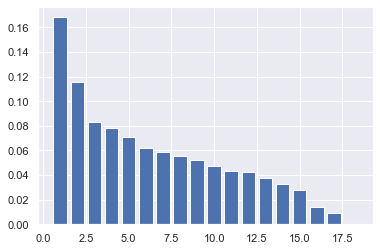

In [296]:
from sklearn.decomposition import PCA

# 元の特徴量と同じ数で主成分分析
pca = PCA(n_components=18)
pca.fit(lgb_train)
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_)


In [182]:
from sklearn.metrics import mean_squared_error as MSE 

In [554]:
pred= model.predict(X_test)
print(np.sqrt(MSE(y_test, pred)))

0.14510821701693163


In [555]:
np.shape(pred)

(100674,)

/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 23455 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 32318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/8skiphone/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/8skiphone/opt/anaconda3/lib/python3.8/

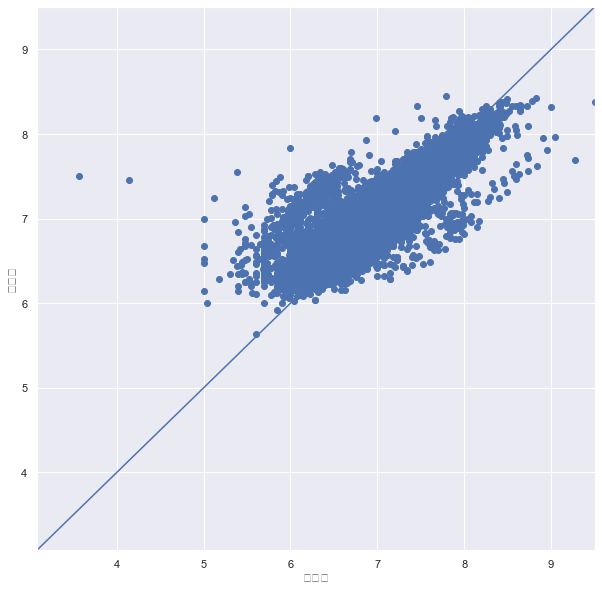

In [556]:
# 1.グラフのサイズを指定し、グラフの大きさを正方形になるように設定する
plt.figure(figsize=(10,10))

# 2.横軸を実測値、縦軸を予測値として、散布図を描く
plt.scatter(y_test,pred)

# 3.値域を揃える為に、y_test、predの両方を見た上での最小値と最大値を求める
min_value = 3.079181
max_value = 9.505150

# 4.最小値と最大値を使い、x軸およびy軸の値域を指定する
plt.xlim([min_value,max_value])
plt.ylim([min_value,max_value])

# 5.対角線を描く
plt.plot([min_value, max_value],[min_value,max_value])

#x軸とy軸に名前を付ける
plt.xlabel("実績値")
plt.ylabel("予測値")

# 可視化結果を表示する為に必要な関数
plt.show()

In [557]:
Z = test
test_pred = model.predict(Z)

In [558]:
Z

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）
0,4,300,2129,2288,8,4,3,2,0,1,1,1000114,1101,2.0,45,1991.0,80.0,400.0
1,4,300,2129,2288,8,4,3,0,0,0,1,1000116,1101,2.0,45,1991.0,80.0,400.0
2,4,300,2129,2288,14,4,3,2,0,0,0,1000117,1101,2.0,50,1989.0,80.0,400.0
3,4,300,2129,2288,14,2,11,2,0,0,0,1000118,1101,3.0,80,1997.0,80.0,400.0
4,4,300,2129,2288,5,2,11,2,0,0,1,1000119,1101,3.0,20,1981.0,80.0,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23199,28,381,2294,2631,19,2,11,2,7,0,1,47012519,47208,NaN,90,2009.0,60.0,200.0
23200,28,361,2251,2631,15,2,11,2,7,0,0,47014760,47211,NaN,65,1989.0,60.0,200.0
23201,28,361,2132,2631,14,2,11,2,8,0,2,47014956,47211,NaN,35,1991.0,50.0,100.0
23202,28,361,3835,2631,14,2,11,2,3,0,1,47015505,47211,NaN,60,1984.0,70.0,200.0


In [559]:
test_pred

array([6.73012132, 6.7209929 , 6.88370328, ..., 6.61161375, 6.83437445,
       7.37753581])

In [560]:
Z['取引価格（総額）_log'] = test_pred
Z

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log
0,4,300,2129,2288,8,4,3,2,0,1,1,1000114,1101,2.0,45,1991.0,80.0,400.0,6.730121
1,4,300,2129,2288,8,4,3,0,0,0,1,1000116,1101,2.0,45,1991.0,80.0,400.0,6.720993
2,4,300,2129,2288,14,4,3,2,0,0,0,1000117,1101,2.0,50,1989.0,80.0,400.0,6.883703
3,4,300,2129,2288,14,2,11,2,0,0,0,1000118,1101,3.0,80,1997.0,80.0,400.0,7.210496
4,4,300,2129,2288,5,2,11,2,0,0,1,1000119,1101,3.0,20,1981.0,80.0,400.0,6.340308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23199,28,381,2294,2631,19,2,11,2,7,0,1,47012519,47208,NaN,90,2009.0,60.0,200.0,7.570743
23200,28,361,2251,2631,15,2,11,2,7,0,0,47014760,47211,NaN,65,1989.0,60.0,200.0,7.019199
23201,28,361,2132,2631,14,2,11,2,8,0,2,47014956,47211,NaN,35,1991.0,50.0,100.0,6.611614
23202,28,361,3835,2631,14,2,11,2,3,0,1,47015505,47211,NaN,60,1984.0,70.0,200.0,6.834374


In [561]:
Z = Z[['ID','取引価格（総額）_log']]

In [562]:
Z

,ID,取引価格（総額）_log
0,1000114,6.730121
1,1000116,6.720993
2,1000117,6.883703
3,1000118,7.210496
4,1000119,6.340308
...,...,...
23199,47012519,7.570743
23200,47014760,7.019199
23201,47014956,6.611614
23202,47015505,6.834374


In [564]:
Z.to_csv('/Users/8skiphone/Desktop/Competition/NISHIKA/中古マンションの住宅価格予測/data/提出データ/test_submission(自作).csv',index = False)

In [121]:
from sklearn.datasets import load_breast_cancer
load_breast_cancer

<function sklearn.datasets._base.load_breast_cancer(*, return_X_y=False, as_frame=False)>

In [122]:
cancer = load_breast_cancer()
X_df = pd.DataFrame(data=cancer.data,columns=cancer.feature_names)
X_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
